# Analisis Big Data untuk Memetakan Prevalensi dan Faktor Risiko HIV

## Modeling & Prediksi - Dataset HIV/AIDS

**Tujuan Modeling:**
- Membuat model prediksi untuk memetakan prevalensi HIV
- Mengidentifikasi faktor risiko yang signifikan
- Membandingkan beberapa algoritma machine learning
- Mengevaluasi performa model dengan metrik yang tepat


In [1]:
# Import Library untuk Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import joblib

# Konfigurasi
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Library untuk modeling berhasil diimport!")
print(f"📅 Tanggal modeling: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ Library untuk modeling berhasil diimport!
📅 Tanggal modeling: 2025-11-25 06:59:14


## 1. Loading Data dari EDA

**Langkah:**
- Memuat dataset yang sudah dibersihkan dari EDA
- Atau memuat ulang dan membersihkan data jika diperlukan


In [2]:
# Membaca dataset utama untuk modeling
print("=" * 80)
print("📂 MEMUAT DATASET UNTUK MODELING")
print("=" * 80)

# Membaca dataset HIV
df_hiv = pd.read_csv('no_of_people_living_with_hiv_by_country_clean.csv')

# Pembersihan data
df_hiv_clean = df_hiv[df_hiv['Count_median'] != 'na'].copy()
df_hiv_clean = df_hiv_clean[df_hiv_clean['Count_median'].notna()].copy()

# Konversi kolom numerik
numeric_cols = ['Year', 'Count_median', 'Count_min', 'Count_max']
for col in numeric_cols:
    if col in df_hiv_clean.columns:
        df_hiv_clean[col] = pd.to_numeric(df_hiv_clean[col], errors='coerce')

df_hiv_clean = df_hiv_clean.dropna(subset=['Count_median'])

print(f"\n✅ Dataset HIV loaded: {df_hiv_clean.shape}")
print(f"\n📊 Preview data:")
print(df_hiv_clean.head())


📂 MEMUAT DATASET UNTUK MODELING

✅ Dataset HIV loaded: (553, 7)

📊 Preview data:
       Country  Year                  Count  Count_median  Count_min  \
0  Afghanistan  2018       7200[4100–11000]        7200.0     4100.0   
2      Algeria  2018     16000[15000–17000]       16000.0    15000.0   
3       Angola  2018  330000[290000–390000]      330000.0   290000.0   
4    Argentina  2018  140000[130000–150000]      140000.0   130000.0   
5      Armenia  2018        3500[3000–4400]        3500.0     3000.0   

   Count_max             WHO Region  
0    11000.0  Eastern Mediterranean  
2    17000.0                 Africa  
3   390000.0                 Africa  
4   150000.0               Americas  
5     4400.0                 Europe  


In [3]:
# Membaca dataset tambahan untuk feature engineering
print("=" * 80)
print("📂 MEMUAT DATASET TAMBAHAN")
print("=" * 80)

df_deaths = pd.read_csv('no_of_deaths_by_country_clean.csv')
df_cases_adults = pd.read_csv('no_of_cases_adults_15_to_49_by_country_clean.csv')

# Pembersihan dataset deaths
df_deaths_clean = df_deaths[df_deaths['Count_median'] != 'na'].copy()
df_deaths_clean = df_deaths_clean[df_deaths_clean['Count_median'].notna()].copy()
df_deaths_clean['Count_median'] = pd.to_numeric(df_deaths_clean['Count_median'], errors='coerce')
df_deaths_clean = df_deaths_clean.dropna(subset=['Count_median'])

# Pembersihan dataset cases adults
df_cases_adults_clean = df_cases_adults[df_cases_adults['Count_median'] != 'na'].copy()
df_cases_adults_clean = df_cases_adults_clean[df_cases_adults_clean['Count_median'].notna()].copy()
df_cases_adults_clean['Count_median'] = pd.to_numeric(df_cases_adults_clean['Count_median'], errors='coerce')
df_cases_adults_clean = df_cases_adults_clean.dropna(subset=['Count_median'])

print(f"\n✅ Dataset Deaths: {df_deaths_clean.shape}")
print(f"✅ Dataset Cases Adults: {df_cases_adults_clean.shape}")


📂 MEMUAT DATASET TAMBAHAN

✅ Dataset Deaths: (400, 7)
✅ Dataset Cases Adults: (556, 7)


## 2. Feature Engineering & Data Preprocessing

**Langkah:**
- Menggabungkan dataset
- Membuat fitur baru
- Encoding kategorikal variables
- Scaling features


In [4]:
# Menggabungkan dataset untuk membuat fitur lengkap
print("=" * 80)
print("🔧 FEATURE ENGINEERING - Menggabungkan Dataset")
print("=" * 80)

# Agregasi per negara (ambil rata-rata jika ada multiple years)
hiv_by_country = df_hiv_clean.groupby(['Country', 'WHO Region']).agg({
    'Count_median': 'mean',
    'Year': 'mean',
    'Count_min': 'mean',
    'Count_max': 'mean'
}).reset_index()
hiv_by_country.rename(columns={'Count_median': 'HIV_Cases'}, inplace=True)

deaths_by_country = df_deaths_clean.groupby('Country')['Count_median'].mean().reset_index()
deaths_by_country.rename(columns={'Count_median': 'AIDS_Deaths'}, inplace=True)

cases_adults_by_country = df_cases_adults_clean.groupby('Country')['Count_median'].mean().reset_index()
cases_adults_by_country.rename(columns={'Count_median': 'Adult_Cases_15_49'}, inplace=True)

# Merge datasets
modeling_df = hiv_by_country.merge(deaths_by_country, on='Country', how='left')
modeling_df = modeling_df.merge(cases_adults_by_country, on='Country', how='left')

print(f"\n✅ Dataset gabungan: {modeling_df.shape}")
print(f"\n📊 Preview data gabungan:")
print(modeling_df.head())


🔧 FEATURE ENGINEERING - Menggabungkan Dataset

✅ Dataset gabungan: (140, 8)

📊 Preview data gabungan:
       Country             WHO Region  HIV_Cases     Year  Count_min  \
0  Afghanistan  Eastern Mediterranean     3975.0  2008.25     2325.0   
1      Algeria                 Africa     7175.0  2008.25     6700.0   
2       Angola                 Africa   196750.0  2008.25   165500.0   
3    Argentina               Americas    99750.0  2008.25    89250.0   
4      Armenia                 Europe     2612.5  2008.25     2095.0   

   Count_max  AIDS_Deaths  Adult_Cases_15_49  
0     6425.0   366.666667              0.100  
1     7650.0   166.666667              0.100  
2   230000.0  9600.000000              1.525  
3   108750.0  1566.666667              0.350  
4     3400.0   166.666667              0.150  


In [5]:
# Membuat fitur-fitur baru (Feature Engineering)
print("=" * 80)
print("🔧 FEATURE ENGINEERING - Membuat Fitur Baru")
print("=" * 80)

# 1. Case Range (ketidakpastian data)
modeling_df['Case_Range'] = modeling_df['Count_max'] - modeling_df['Count_min']

# 2. Case Range Ratio (persentase ketidakpastian)
modeling_df['Case_Range_Ratio'] = (modeling_df['Case_Range'] / modeling_df['HIV_Cases']).fillna(0)

# 3. Death Rate per 1000 cases
modeling_df['Death_Rate'] = (modeling_df['AIDS_Deaths'] / modeling_df['HIV_Cases'] * 1000).fillna(0)

# 4. Adult Cases Ratio (proporsi kasus dewasa)
modeling_df['Adult_Cases_Ratio'] = (modeling_df['Adult_Cases_15_49'] / modeling_df['HIV_Cases']).fillna(0)

# 5. Log transformation untuk mengurangi skewness
modeling_df['Log_HIV_Cases'] = np.log1p(modeling_df['HIV_Cases'])

# 6. Tahun sebagai fitur (normalisasi)
modeling_df['Year_Normalized'] = (modeling_df['Year'] - modeling_df['Year'].min()) / (modeling_df['Year'].max() - modeling_df['Year'].min())

print("\n✅ Fitur baru berhasil dibuat!")
print(f"\n📋 Kolom dalam dataset:")
print(modeling_df.columns.tolist())
print(f"\n📊 Statistik fitur baru:")
print(modeling_df[['Case_Range', 'Death_Rate', 'Adult_Cases_Ratio', 'Year_Normalized']].describe())


🔧 FEATURE ENGINEERING - Membuat Fitur Baru

✅ Fitur baru berhasil dibuat!

📋 Kolom dalam dataset:
['Country', 'WHO Region', 'HIV_Cases', 'Year', 'Count_min', 'Count_max', 'AIDS_Deaths', 'Adult_Cases_15_49', 'Case_Range', 'Case_Range_Ratio', 'Death_Rate', 'Adult_Cases_Ratio', 'Log_HIV_Cases', 'Year_Normalized']

📊 Statistik fitur baru:
         Case_Range  Death_Rate  Adult_Cases_Ratio  Year_Normalized
count  1.400000e+02  140.000000         140.000000       140.000000
mean   5.703760e+04   63.239804           0.000071         0.254533
std    1.492191e+05   90.446625           0.000123         0.067868
min    0.000000e+00    0.000000           0.000000         0.000000
25%    1.376250e+03   28.994719           0.000008         0.250000
50%    7.936250e+03   43.833613           0.000020         0.250000
75%    4.118750e+04   55.538582           0.000060         0.250000
max    1.025000e+06  666.666667           0.000667         1.000000


In [6]:
# Encoding variabel kategorikal dan persiapan data modeling
print("=" * 80)
print("🔧 DATA PREPROCESSING - Encoding Kategorikal")
print("=" * 80)

# Encoding WHO Region menggunakan Label Encoding
le_region = LabelEncoder()
modeling_df['WHO_Region_Encoded'] = le_region.fit_transform(modeling_df['WHO Region'])

print(f"\n📊 Mapping WHO Region:")
for i, region in enumerate(le_region.classes_):
    print(f"   {i}: {region}")

# Hapus kolom yang tidak diperlukan untuk modeling
columns_to_drop = ['Country', 'WHO Region', 'Count_min', 'Count_max']

# Hapus kolom yang akan digunakan sebagai target atau tidak diperlukan
modeling_df_clean = modeling_df.drop(columns=columns_to_drop, errors='ignore')

# Hapus missing values
modeling_df_clean = modeling_df_clean.dropna()

print(f"\n✅ Dataset siap untuk modeling: {modeling_df_clean.shape}")
print(f"\n📊 Preview data final:")
print(modeling_df_clean.head())


🔧 DATA PREPROCESSING - Encoding Kategorikal

📊 Mapping WHO Region:
   0: Africa
   1: Americas
   2: Eastern Mediterranean
   3: Europe
   4: South-East Asia
   5: Western Pacific

✅ Dataset siap untuk modeling: (134, 11)

📊 Preview data final:
   HIV_Cases     Year  AIDS_Deaths  Adult_Cases_15_49  Case_Range  \
0     3975.0  2008.25   366.666667              0.100      4100.0   
1     7175.0  2008.25   166.666667              0.100       950.0   
2   196750.0  2008.25  9600.000000              1.525     64500.0   
3    99750.0  2008.25  1566.666667              0.350     19500.0   
4     2612.5  2008.25   166.666667              0.150      1305.0   

   Case_Range_Ratio  Death_Rate  Adult_Cases_Ratio  Log_HIV_Cases  \
0          1.031447   92.243187           0.000025       8.288032   
1          0.132404   23.228804           0.000014       8.878497   
2          0.327827   48.792884           0.000008      12.189694   
3          0.195489   15.705931           0.000004      11.51043

## 3. Menentukan Features dan Target

**Langkah:**
- Memilih fitur (X) dan target (y)
- Visualisasi korelasi fitur dengan target


In [7]:
# Menentukan Features (X) dan Target (y)
print("=" * 80)
print("🎯 MENENTUKAN FEATURES DAN TARGET")
print("=" * 80)

# Target: HIV_Cases (jumlah orang hidup dengan HIV)
# Features: Semua kolom kecuali target dan Log_HIV_Cases
target_col = 'HIV_Cases'
feature_cols = [col for col in modeling_df_clean.columns 
                if col not in [target_col, 'Log_HIV_Cases']]

X = modeling_df_clean[feature_cols]
y = modeling_df_clean[target_col]

print(f"\n📊 Features yang digunakan ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i}. {col}")

print(f"\n🎯 Target: {target_col}")
print(f"\n📏 Shape:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

print(f"\n📊 Info Features:")
print(X.info())


🎯 MENENTUKAN FEATURES DAN TARGET

📊 Features yang digunakan (9):
   1. Year
   2. AIDS_Deaths
   3. Adult_Cases_15_49
   4. Case_Range
   5. Case_Range_Ratio
   6. Death_Rate
   7. Adult_Cases_Ratio
   8. Year_Normalized
   9. WHO_Region_Encoded

🎯 Target: HIV_Cases

📏 Shape:
   X: (134, 9)
   y: (134,)

📊 Info Features:
<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 0 to 139
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                134 non-null    float64
 1   AIDS_Deaths         134 non-null    float64
 2   Adult_Cases_15_49   134 non-null    float64
 3   Case_Range          134 non-null    float64
 4   Case_Range_Ratio    134 non-null    float64
 5   Death_Rate          134 non-null    float64
 6   Adult_Cases_Ratio   134 non-null    float64
 7   Year_Normalized     134 non-null    float64
 8   WHO_Region_Encoded  134 non-null    int64  
dtypes: float64(8), int64(1)
memory usa

📊 KORELASI FITUR DENGAN TARGET

🔗 Korelasi setiap fitur dengan target:
AIDS_Deaths           0.907662
Case_Range            0.884294
Adult_Cases_15_49     0.492103
Year_Normalized       0.026408
Year                  0.026408
Case_Range_Ratio     -0.088962
Death_Rate           -0.107529
Adult_Cases_Ratio    -0.168238
WHO_Region_Encoded   -0.269120
Name: HIV_Cases, dtype: float64


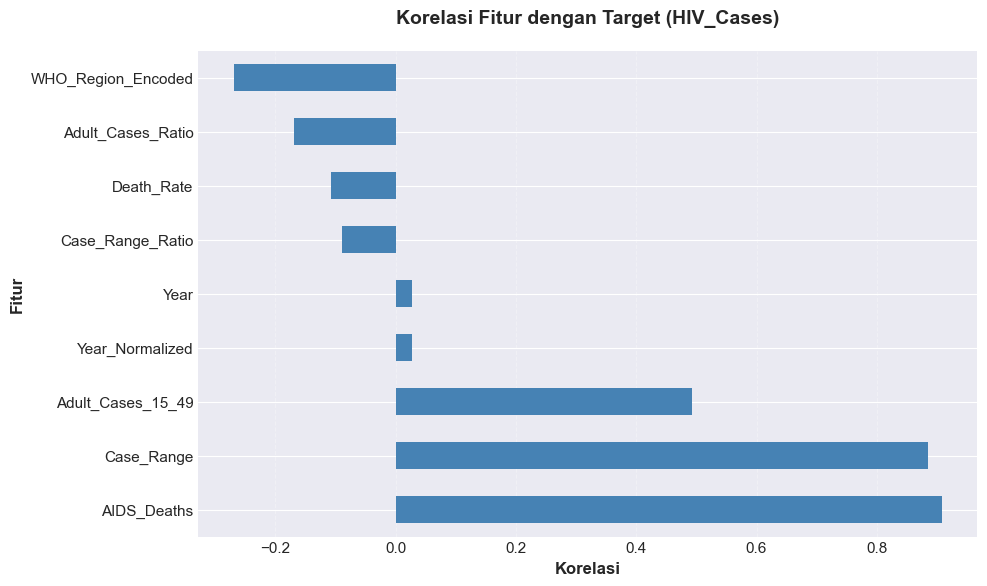


✅ Korelasi berhasil dianalisis!


In [8]:
# Analisis korelasi fitur dengan target
print("=" * 80)
print("📊 KORELASI FITUR DENGAN TARGET")
print("=" * 80)

# Gabungkan X dan y untuk korelasi
corr_df = pd.concat([X, y], axis=1)
correlation_with_target = corr_df.corr()[target_col].sort_values(ascending=False)

print("\n🔗 Korelasi setiap fitur dengan target:")
print(correlation_with_target.drop(target_col))

# Visualisasi korelasi
plt.figure(figsize=(10, 6))
correlation_with_target.drop(target_col).plot(kind='barh', color='steelblue')
plt.title('Korelasi Fitur dengan Target (HIV_Cases)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Korelasi', fontsize=12, fontweight='bold')
plt.ylabel('Fitur', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

print("\n✅ Korelasi berhasil dianalisis!")


In [9]:
# Train-Test Split
print("=" * 80)
print("✂️ TRAIN-TEST SPLIT")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"\n📏 Ukuran Data:")
print(f"   Total: {len(X)} sampel")
print(f"   Train: {len(X_train)} sampel ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test: {len(X_test)} sampel ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n📊 Statistik Target (Train):")
print(f"   Mean: {y_train.mean():,.0f}")
print(f"   Median: {y_train.median():,.0f}")
print(f"   Std: {y_train.std():,.0f}")

print(f"\n📊 Statistik Target (Test):")
print(f"   Mean: {y_test.mean():,.0f}")
print(f"   Median: {y_test.median():,.0f}")
print(f"   Std: {y_test.std():,.0f}")


✂️ TRAIN-TEST SPLIT

📏 Ukuran Data:
   Total: 134 sampel
   Train: 107 sampel (79.9%)
   Test: 27 sampel (20.1%)

📊 Statistik Target (Train):
   Mean: 200,042
   Median: 23,000
   Std: 614,811

📊 Statistik Target (Test):
   Mean: 135,301
   Median: 13,750
   Std: 294,262


In [10]:
# Feature Scaling
print("=" * 80)
print("🔧 FEATURE SCALING")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame untuk kemudahan
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n✅ Features berhasil di-scale!")
print(f"\n📊 Statistik Features (Scaled) - Train:")
print(X_train_scaled.describe().round(3))

print(f"\n💾 Scaler berhasil dibuat dan siap digunakan untuk prediksi data baru")


🔧 FEATURE SCALING

✅ Features berhasil di-scale!

📊 Statistik Features (Scaled) - Train:
          Year  AIDS_Deaths  Adult_Cases_15_49  Case_Range  Case_Range_Ratio  \
count  107.000      107.000            107.000     107.000           107.000   
mean     0.000        0.000              0.000       0.000            -0.000   
std      1.005        1.005              1.005       1.005             1.005   
min    -10.296       -0.418             -0.440      -0.363            -1.535   
25%      0.097       -0.411             -0.437      -0.353            -0.671   
50%      0.097       -0.380             -0.386      -0.316            -0.282   
75%      0.097       -0.173             -0.149      -0.113             0.335   
max      0.097        5.675              4.756       5.966             3.294   

       Death_Rate  Adult_Cases_Ratio  Year_Normalized  WHO_Region_Encoded  
count     107.000            107.000          107.000             107.000  
mean        0.000             -0.000  

## 5. Model 1: Linear Regression

**Langkah:**
- Membuat model Linear Regression
- Training model
- Evaluasi model


In [11]:
# Model 1: Linear Regression
print("=" * 80)
print("🤖 MODEL 1: LINEAR REGRESSION")
print("=" * 80)

# Training model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Prediksi
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluasi
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("\n📊 METRIK EVALUASI:")
print(f"\n   Train Set:")
print(f"   - RMSE: {train_rmse_lr:,.0f}")
print(f"   - MAE: {train_mae_lr:,.0f}")
print(f"   - R² Score: {train_r2_lr:.4f}")

print(f"\n   Test Set:")
print(f"   - RMSE: {test_rmse_lr:,.0f}")
print(f"   - MAE: {test_mae_lr:,.0f}")
print(f"   - R² Score: {test_r2_lr:.4f}")

print(f"\n✅ Model Linear Regression berhasil dilatih!")


🤖 MODEL 1: LINEAR REGRESSION

📊 METRIK EVALUASI:

   Train Set:
   - RMSE: 242,458
   - MAE: 90,226
   - R² Score: 0.8430

   Test Set:
   - RMSE: 99,102
   - MAE: 63,492
   - R² Score: 0.8822

✅ Model Linear Regression berhasil dilatih!


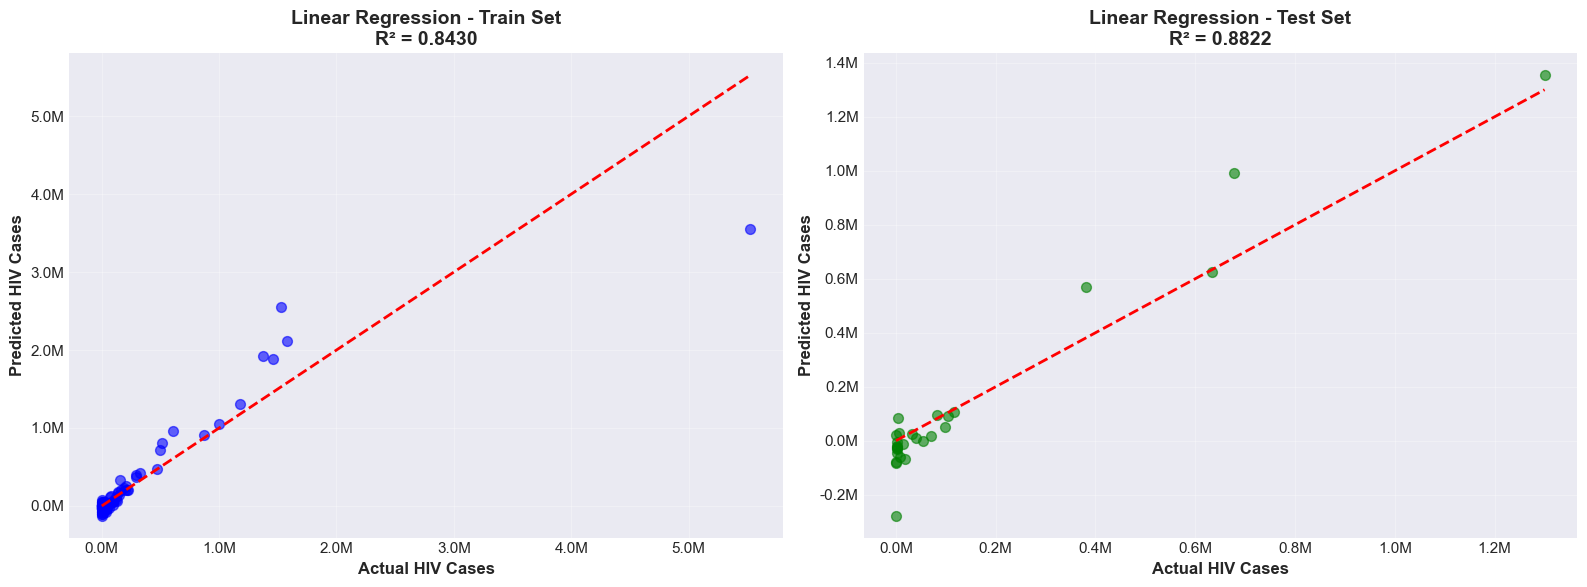

✅ Visualisasi Linear Regression berhasil dibuat!


In [12]:
# Visualisasi Hasil Linear Regression
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_lr, alpha=0.6, color='blue', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual HIV Cases', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted HIV Cases', fontsize=12, fontweight='bold')
axes[0].set_title(f'Linear Regression - Train Set\nR² = {train_r2_lr:.4f}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_lr, alpha=0.6, color='green', s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual HIV Cases', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted HIV Cases', fontsize=12, fontweight='bold')
axes[1].set_title(f'Linear Regression - Test Set\nR² = {test_r2_lr:.4f}', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Format axes
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("✅ Visualisasi Linear Regression berhasil dibuat!")


## 6. Model 2: Random Forest Regressor

**Langkah:**
- Membuat model Random Forest
- Training model
- Evaluasi model


In [13]:
# Model 2: Random Forest Regressor
print("=" * 80)
print("🤖 MODEL 2: RANDOM FOREST REGRESSOR")
print("=" * 80)

# Training model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Prediksi
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Evaluasi
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n📊 METRIK EVALUASI:")
print(f"\n   Train Set:")
print(f"   - RMSE: {train_rmse_rf:,.0f}")
print(f"   - MAE: {train_mae_rf:,.0f}")
print(f"   - R² Score: {train_r2_rf:.4f}")

print(f"\n   Test Set:")
print(f"   - RMSE: {test_rmse_rf:,.0f}")
print(f"   - MAE: {test_mae_rf:,.0f}")
print(f"   - R² Score: {test_r2_rf:.4f}")

print(f"\n✅ Model Random Forest berhasil dilatih!")


🤖 MODEL 2: RANDOM FOREST REGRESSOR

📊 METRIK EVALUASI:

   Train Set:
   - RMSE: 139,228
   - MAE: 26,579
   - R² Score: 0.9482

   Test Set:
   - RMSE: 47,274
   - MAE: 22,377
   - R² Score: 0.9732

✅ Model Random Forest berhasil dilatih!


📊 FEATURE IMPORTANCE - Random Forest

🔝 Top 10 Fitur Paling Penting:
           Feature   Importance
       AIDS_Deaths 7.183921e-01
        Case_Range 2.573086e-01
 Adult_Cases_15_49 1.034893e-02
  Case_Range_Ratio 6.858325e-03
        Death_Rate 5.080239e-03
 Adult_Cases_Ratio 1.672483e-03
WHO_Region_Encoded 3.392189e-04
              Year 1.125295e-07
   Year_Normalized 1.553388e-08


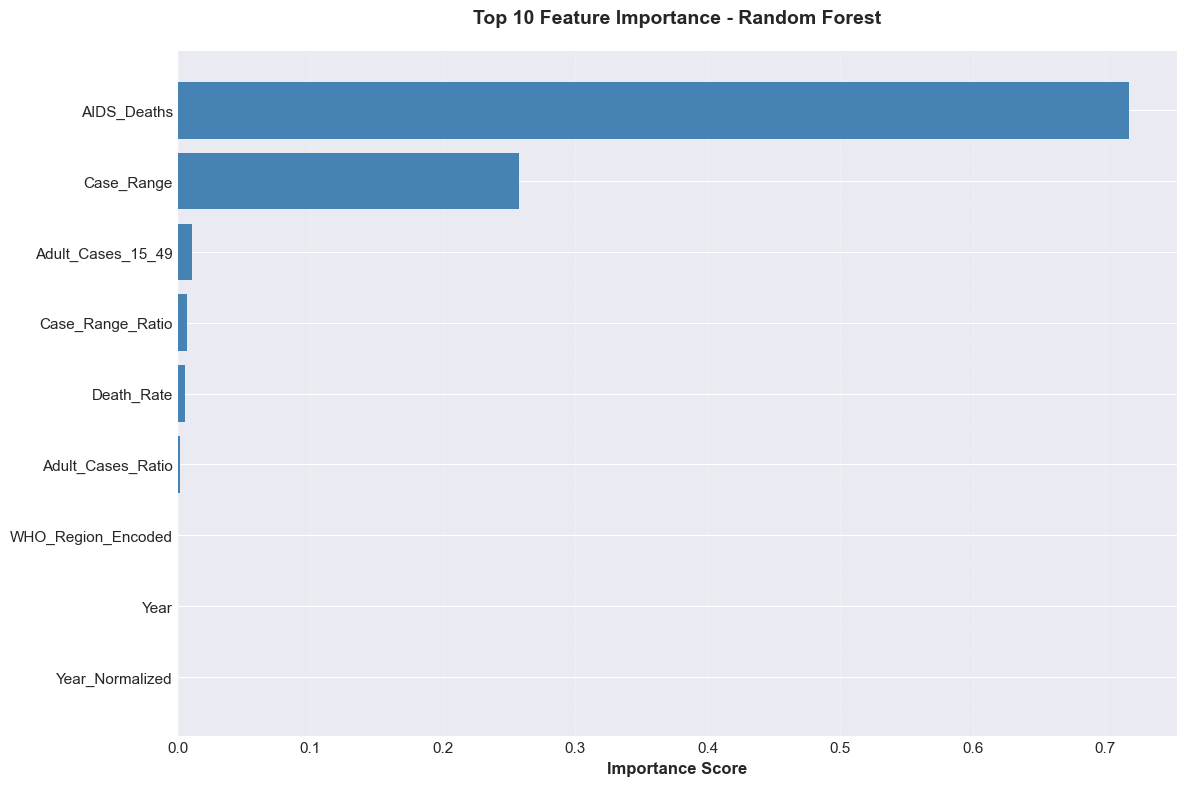


✅ Feature importance berhasil dianalisis!


In [14]:
# Feature Importance dari Random Forest
print("=" * 80)
print("📊 FEATURE IMPORTANCE - Random Forest")
print("=" * 80)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔝 Top 10 Fitur Paling Penting:")
print(feature_importance.head(10).to_string(index=False))

# Visualisasi Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Top 10 Feature Importance - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

print("\n✅ Feature importance berhasil dianalisis!")


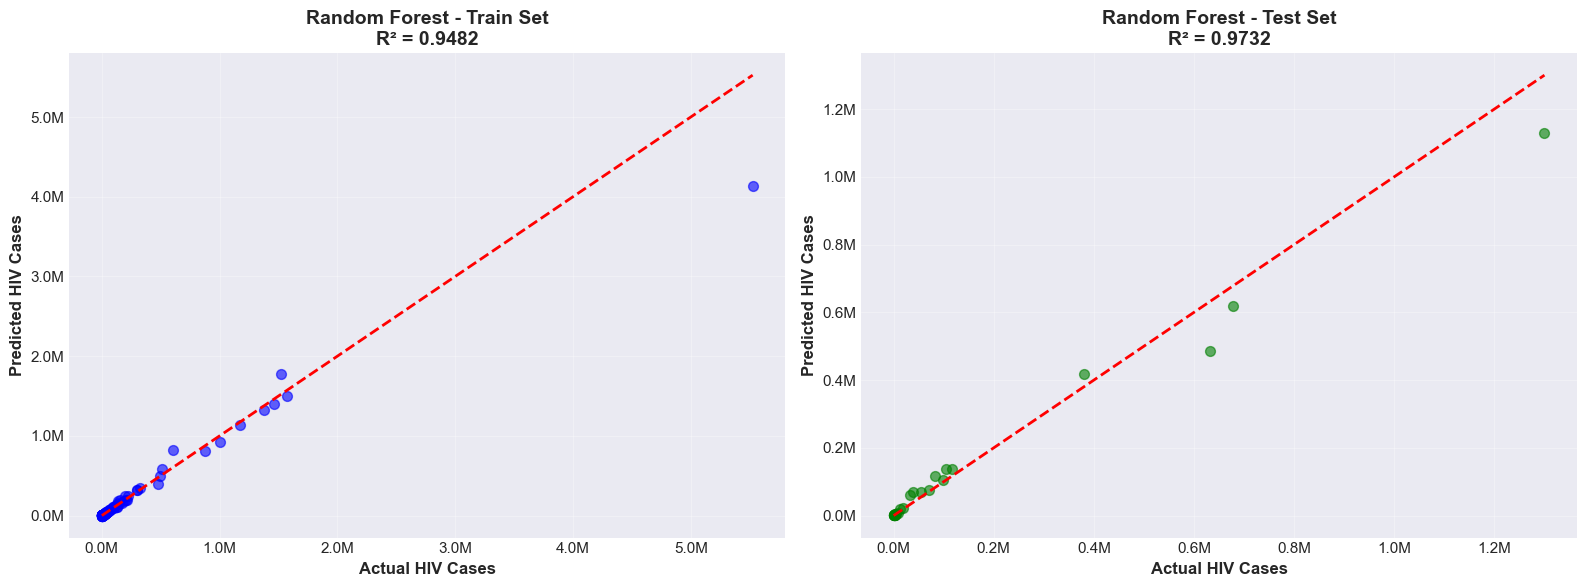

✅ Visualisasi Random Forest berhasil dibuat!


In [15]:
# Visualisasi Hasil Random Forest
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_rf, alpha=0.6, color='blue', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual HIV Cases', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted HIV Cases', fontsize=12, fontweight='bold')
axes[0].set_title(f'Random Forest - Train Set\nR² = {train_r2_rf:.4f}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.6, color='green', s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual HIV Cases', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted HIV Cases', fontsize=12, fontweight='bold')
axes[1].set_title(f'Random Forest - Test Set\nR² = {test_r2_rf:.4f}', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Format axes
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("✅ Visualisasi Random Forest berhasil dibuat!")


## 7. Model 3: Gradient Boosting Regressor

**Langkah:**
- Membuat model Gradient Boosting
- Training model
- Evaluasi model


In [16]:
# Model 3: Gradient Boosting Regressor
print("=" * 80)
print("🤖 MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("=" * 80)

# Training model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# Prediksi
y_train_pred_gb = gb_model.predict(X_train_scaled)
y_test_pred_gb = gb_model.predict(X_test_scaled)

# Evaluasi
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb)
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
train_r2_gb = r2_score(y_train, y_train_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

print("\n📊 METRIK EVALUASI:")
print(f"\n   Train Set:")
print(f"   - RMSE: {train_rmse_gb:,.0f}")
print(f"   - MAE: {train_mae_gb:,.0f}")
print(f"   - R² Score: {train_r2_gb:.4f}")

print(f"\n   Test Set:")
print(f"   - RMSE: {test_rmse_gb:,.0f}")
print(f"   - MAE: {test_mae_gb:,.0f}")
print(f"   - R² Score: {test_r2_gb:.4f}")

print(f"\n✅ Model Gradient Boosting berhasil dilatih!")


🤖 MODEL 3: GRADIENT BOOSTING REGRESSOR

📊 METRIK EVALUASI:

   Train Set:
   - RMSE: 295
   - MAE: 223
   - R² Score: 1.0000

   Test Set:
   - RMSE: 66,534
   - MAE: 25,254
   - R² Score: 0.9469

✅ Model Gradient Boosting berhasil dilatih!


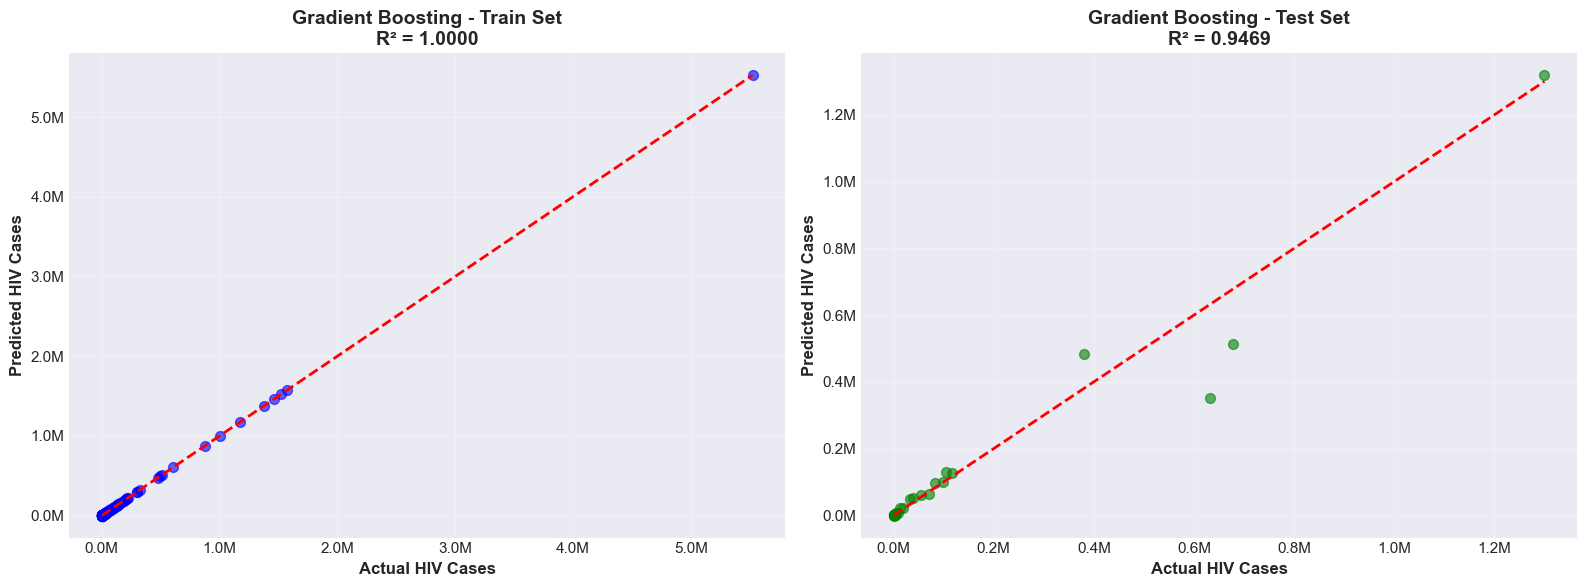

✅ Visualisasi Gradient Boosting berhasil dibuat!


In [17]:
# Visualisasi Hasil Gradient Boosting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_gb, alpha=0.6, color='blue', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual HIV Cases', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted HIV Cases', fontsize=12, fontweight='bold')
axes[0].set_title(f'Gradient Boosting - Train Set\nR² = {train_r2_gb:.4f}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_gb, alpha=0.6, color='green', s=50)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual HIV Cases', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted HIV Cases', fontsize=12, fontweight='bold')
axes[1].set_title(f'Gradient Boosting - Test Set\nR² = {test_r2_gb:.4f}', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Format axes
for ax in axes:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("✅ Visualisasi Gradient Boosting berhasil dibuat!")


## 8. Model Comparison & Evaluation

**Langkah:**
- Membandingkan performa semua model
- Visualisasi perbandingan
- Memilih model terbaik


In [18]:
# Perbandingan Semua Model
print("=" * 80)
print("📊 PERBANDINGAN SEMUA MODEL")
print("=" * 80)

# Buat dataframe perbandingan
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Train RMSE': [train_rmse_lr, train_rmse_rf, train_rmse_gb],
    'Test RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_gb],
    'Train MAE': [train_mae_lr, train_mae_rf, train_mae_gb],
    'Test MAE': [test_mae_lr, test_mae_rf, test_mae_gb],
    'Train R²': [train_r2_lr, train_r2_rf, train_r2_gb],
    'Test R²': [test_r2_lr, test_r2_rf, test_r2_gb]
})

print("\n📈 Tabel Perbandingan Model:")
print(comparison_df.round(2).to_string(index=False))

# Identifikasi model terbaik berdasarkan Test R²
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n🏆 MODEL TERBAIK: {best_model_name}")
print(f"   Test R² Score: {comparison_df.loc[best_model_idx, 'Test R²']:.4f}")
print(f"   Test RMSE: {comparison_df.loc[best_model_idx, 'Test RMSE']:,.0f}")
print(f"   Test MAE: {comparison_df.loc[best_model_idx, 'Test MAE']:,.0f}")


📊 PERBANDINGAN SEMUA MODEL

📈 Tabel Perbandingan Model:
            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
Linear Regression   242457.77   99101.92   90225.94  63491.71      0.84     0.88
    Random Forest   139227.95   47274.48   26579.42  22376.82      0.95     0.97
Gradient Boosting      295.33   66533.72     222.67  25253.70      1.00     0.95

🏆 MODEL TERBAIK: Random Forest
   Test R² Score: 0.9732
   Test RMSE: 47,274
   Test MAE: 22,377


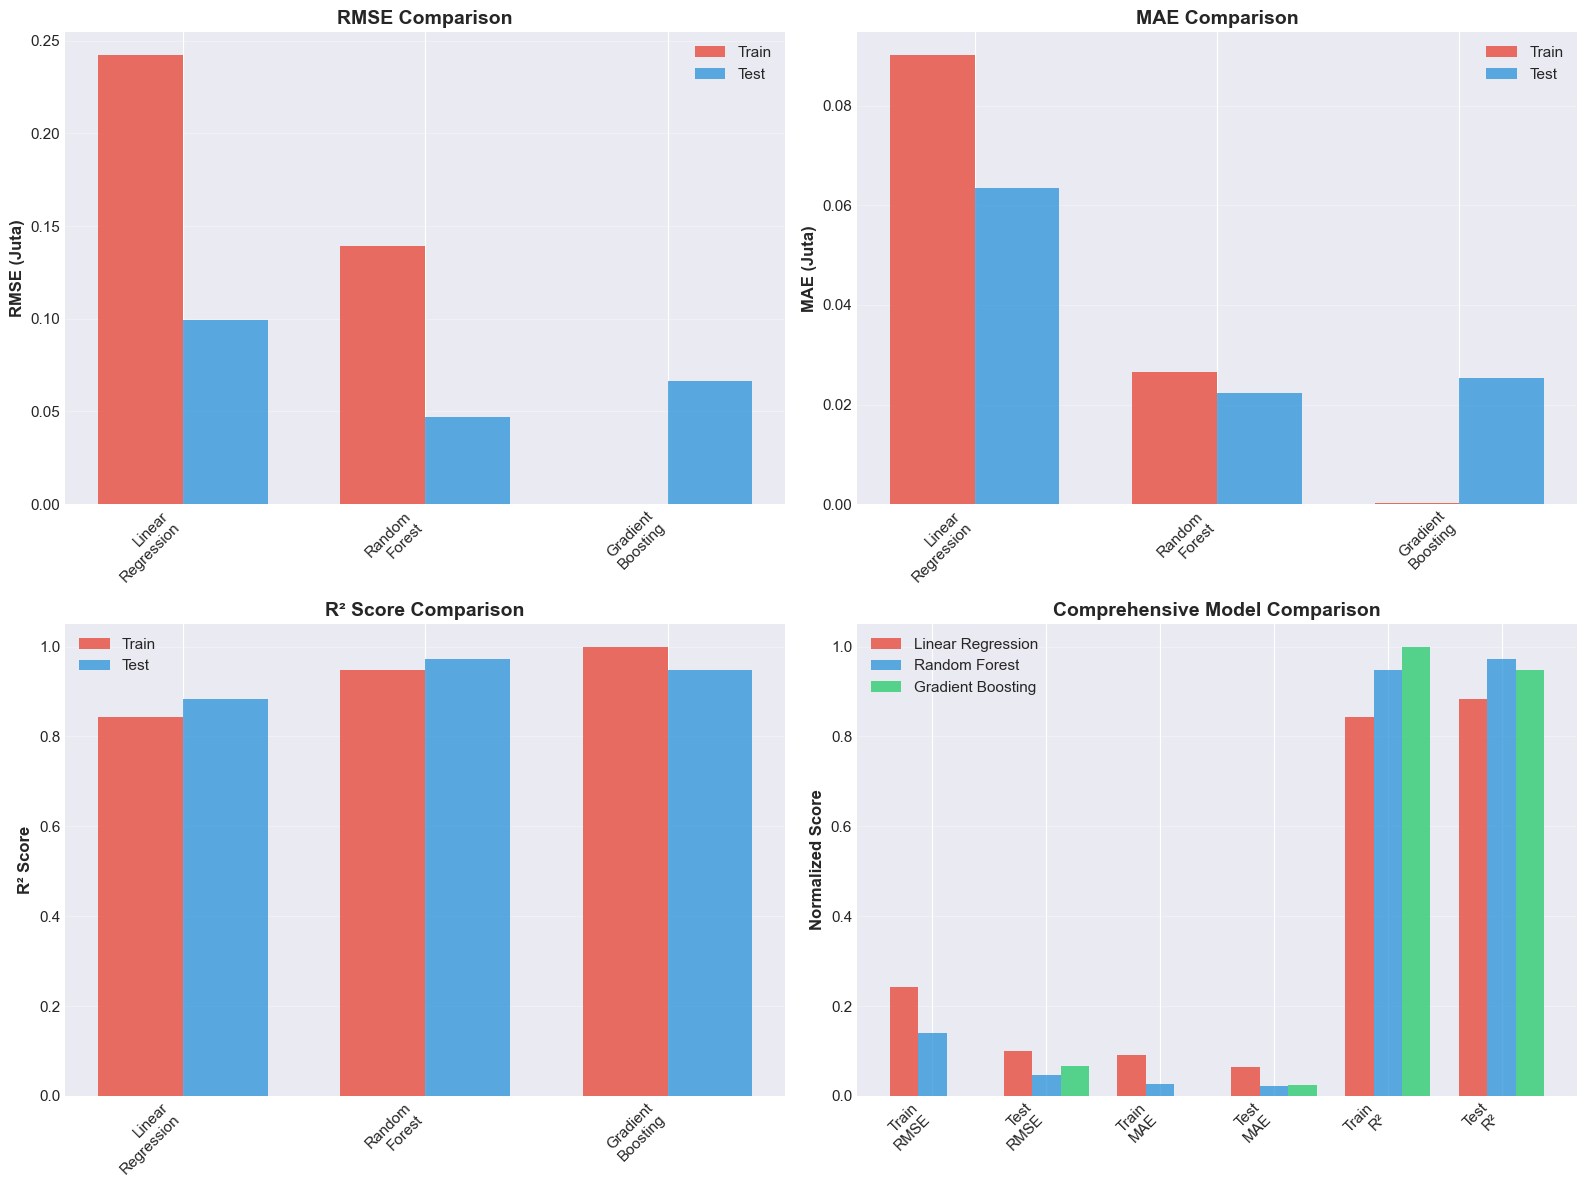

✅ Visualisasi perbandingan model berhasil dibuat!


In [19]:
# Visualisasi Perbandingan Model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gunakan semua model dari comparison_df
models = comparison_df['Model'].tolist()
models_labels = [m.replace(' ', '\n') for m in models]  # Ganti spasi dengan newline untuk label
colors = ['#e74c3c', '#3498db', '#2ecc71']

# 1. RMSE Comparison
x_pos = np.arange(len(models))
width = 0.35
axes[0, 0].bar(x_pos - width/2, comparison_df['Train RMSE']/1e6, width, label='Train', color=colors[0], alpha=0.8)
axes[0, 0].bar(x_pos + width/2, comparison_df['Test RMSE']/1e6, width, label='Test', color=colors[1], alpha=0.8)
axes[0, 0].set_ylabel('RMSE (Juta)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models_labels, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. MAE Comparison
axes[0, 1].bar(x_pos - width/2, comparison_df['Train MAE']/1e6, width, label='Train', color=colors[0], alpha=0.8)
axes[0, 1].bar(x_pos + width/2, comparison_df['Test MAE']/1e6, width, label='Test', color=colors[1], alpha=0.8)
axes[0, 1].set_ylabel('MAE (Juta)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models_labels, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. R² Score Comparison
axes[1, 0].bar(x_pos - width/2, comparison_df['Train R²'], width, label='Train', color=colors[0], alpha=0.8)
axes[1, 0].bar(x_pos + width/2, comparison_df['Test R²'], width, label='Test', color=colors[1], alpha=0.8)
axes[1, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models_labels, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 4. Model Performance Summary
metrics = ['Train\nRMSE', 'Test\nRMSE', 'Train\nMAE', 'Test\nMAE', 'Train\nR²', 'Test\nR²']
lr_scores = [train_rmse_lr/1e6, test_rmse_lr/1e6, train_mae_lr/1e6, test_mae_lr/1e6, train_r2_lr, test_r2_lr]
rf_scores = [train_rmse_rf/1e6, test_rmse_rf/1e6, train_mae_rf/1e6, test_mae_rf/1e6, train_r2_rf, test_r2_rf]
gb_scores = [train_rmse_gb/1e6, test_rmse_gb/1e6, train_mae_gb/1e6, test_mae_gb/1e6, train_r2_gb, test_r2_gb]

x_metrics = np.arange(len(metrics))
width_bar = 0.25
axes[1, 1].bar(x_metrics - width_bar, lr_scores, width_bar, label='Linear Regression', color=colors[0], alpha=0.8)
axes[1, 1].bar(x_metrics, rf_scores, width_bar, label='Random Forest', color=colors[1], alpha=0.8)
axes[1, 1].bar(x_metrics + width_bar, gb_scores, width_bar, label='Gradient Boosting', color=colors[2], alpha=0.8)
axes[1, 1].set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Comprehensive Model Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_metrics)
axes[1, 1].set_xticklabels(metrics, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Visualisasi perbandingan model berhasil dibuat!")


## 9. Prediksi untuk Data Baru

**Langkah:**
- Membuat fungsi prediksi
- Contoh prediksi untuk negara tertentu


In [20]:
# Fungsi untuk prediksi HIV Cases
print("=" * 80)
print("🔮 FUNGSI PREDIKSI")
print("=" * 80)

def predict_hiv_cases(country_data, model, scaler, feature_cols, le_region=None):
    """
    Fungsi untuk memprediksi jumlah HIV cases berdasarkan data negara
    
    Parameters:
    - country_data: dict dengan keys sesuai feature_cols
    - model: model yang sudah dilatih
    - scaler: scaler yang sudah di-fit
    - feature_cols: list nama kolom features
    - le_region: LabelEncoder untuk WHO Region (opsional)
    """
    # Buat DataFrame dari input
    df_input = pd.DataFrame([country_data])
    
    # Encoding WHO Region jika diperlukan
    if 'WHO_Region_Encoded' in feature_cols and le_region:
        if 'WHO Region' in df_input.columns:
            df_input['WHO_Region_Encoded'] = le_region.transform(df_input['WHO Region'])
    
    # Pastikan semua kolom ada
    for col in feature_cols:
        if col not in df_input.columns:
            df_input[col] = 0
    
    # Reorder kolom sesuai dengan feature_cols
    df_input = df_input[feature_cols]
    
    # Scaling
    df_input_scaled = scaler.transform(df_input)
    
    # Prediksi
    prediction = model.predict(df_input_scaled)[0]
    
    return prediction

print("\n✅ Fungsi prediksi berhasil dibuat!")
print("\n💡 Contoh penggunaan:")
print("   prediction = predict_hiv_cases(country_data, rf_model, scaler, feature_cols, le_region)")


🔮 FUNGSI PREDIKSI

✅ Fungsi prediksi berhasil dibuat!

💡 Contoh penggunaan:
   prediction = predict_hiv_cases(country_data, rf_model, scaler, feature_cols, le_region)


In [21]:
# Contoh Prediksi untuk Beberapa Negara
print("=" * 80)
print("🔮 CONTOH PREDIKSI UNTUK DATA BARU")
print("=" * 80)

# Ambil beberapa negara dari test set sebagai contoh
sample_countries = modeling_df[modeling_df['Country'].isin(X_test.index.map(lambda x: modeling_df.iloc[x]['Country'] if x < len(modeling_df) else None))].head(5)

# Gunakan Random Forest sebagai model untuk prediksi (model terbaik)
predictions_dict = {}
actual_dict = {}

for idx, row in sample_countries.iterrows():
    country = row['Country']
    
    # Siapkan data untuk prediksi
    country_data = {
        'Year': row['Year'],
        'Year_Normalized': row['Year_Normalized'],
        'AIDS_Deaths': row.get('AIDS_Deaths', 0),
        'Adult_Cases_15_49': row.get('Adult_Cases_15_49', 0),
        'Case_Range': row.get('Case_Range', 0),
        'Case_Range_Ratio': row.get('Case_Range_Ratio', 0),
        'Death_Rate': row.get('Death_Rate', 0),
        'Adult_Cases_Ratio': row.get('Adult_Cases_Ratio', 0),
        'WHO Region': row['WHO Region']
    }
    
    # Prediksi
    try:
        prediction = predict_hiv_cases(country_data, rf_model, scaler, feature_cols, le_region)
        actual = row['HIV_Cases']
        
        predictions_dict[country] = prediction
        actual_dict[country] = actual
        
        print(f"\n🌍 {country}:")
        print(f"   Actual: {actual:,.0f}")
        print(f"   Predicted: {prediction:,.0f}")
        print(f"   Error: {abs(actual - prediction):,.0f} ({abs((actual-prediction)/actual*100):.2f}%)")
    except Exception as e:
        print(f"\n❌ Error untuk {country}: {str(e)}")

print("\n✅ Prediksi contoh berhasil dilakukan!")


🔮 CONTOH PREDIKSI UNTUK DATA BARU

🌍 Armenia:
   Actual: 2,612
   Predicted: 3,390
   Error: 778 (29.76%)

🌍 Belize:
   Actual: 3,275
   Predicted: 2,597
   Error: 678 (20.69%)

🌍 Bhutan:
   Actual: 1,058
   Predicted: 2,677
   Error: 1,620 (153.16%)

🌍 Brazil:
   Actual: 632,500
   Predicted: 484,785
   Error: 147,715 (23.35%)

🌍 Burkina Faso:
   Actual: 116,500
   Predicted: 137,865
   Error: 21,365 (18.34%)

✅ Prediksi contoh berhasil dilakukan!


## 10. Menyimpan Model & Kesimpulan

**Langkah:**
- Menyimpan model terbaik
- Menyimpan scaler dan encoder
- Ringkasan hasil modeling


In [22]:
# Menyimpan Model Terbaik
print("=" * 80)
print("💾 MENYIMPAN MODEL TERBAIK")
print("=" * 80)

# Tentukan model terbaik berdasarkan Test R²
if test_r2_rf >= test_r2_lr:
    best_model = rf_model
    best_model_name = "Random Forest"
else:
    best_model = lr_model
    best_model_name = "Linear Regression"

# Simpan model
joblib.dump(best_model, 'best_hiv_prediction_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(le_region, 'region_encoder.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

print(f"\n✅ Model terbaik ({best_model_name}) berhasil disimpan!")
print("\n📁 File yang disimpan:")
print("   - best_hiv_prediction_model.pkl")
print("   - feature_scaler.pkl")
print("   - region_encoder.pkl")
print("   - feature_columns.pkl")

# Simpan comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("   - model_comparison_results.csv")


💾 MENYIMPAN MODEL TERBAIK

✅ Model terbaik (Random Forest) berhasil disimpan!

📁 File yang disimpan:
   - best_hiv_prediction_model.pkl
   - feature_scaler.pkl
   - region_encoder.pkl
   - feature_columns.pkl
   - model_comparison_results.csv


In [23]:
# Ringkasan Hasil Modeling
print("=" * 80)
print("📋 RINGKASAN HASIL MODELING")
print("=" * 80)

print("\n✅ HASIL MODELING:")
print(f"\n1. DATA PREPARATION:")
print(f"   - Total sampel: {len(X)} negara")
print(f"   - Train set: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"   - Jumlah features: {len(feature_cols)}")

print(f"\n2. MODEL YANG DILATIH:")
print(f"   - Linear Regression")
print(f"   - Random Forest Regressor")

print(f"\n3. MODEL TERBAIK: {best_model_name}")
if best_model_name == "Random Forest":
    print(f"   - Test R² Score: {test_r2_rf:.4f}")
    print(f"   - Test RMSE: {test_rmse_rf:,.0f}")
    print(f"   - Test MAE: {test_mae_rf:,.0f}")
else:
    print(f"   - Test R² Score: {test_r2_lr:.4f}")
    print(f"   - Test RMSE: {test_rmse_lr:,.0f}")
    print(f"   - Test MAE: {test_mae_lr:,.0f}")

print(f"\n4. FITUR PENTING (dari Random Forest):")
top_5_features = feature_importance.head(5)
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"   {i}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n5. KESIMPULAN:")
print(f"   ✅ Model berhasil dibuat dan dievaluasi")
print(f"   ✅ Model terbaik dapat digunakan untuk memprediksi prevalensi HIV")
print(f"   ✅ Model dan preprocessing tools telah disimpan untuk penggunaan selanjutnya")

print("\n" + "=" * 80)
print("✅ MODELING SELESAI - Siap untuk deployment dan visualisasi dashboard!")
print("=" * 80)


📋 RINGKASAN HASIL MODELING

✅ HASIL MODELING:

1. DATA PREPARATION:
   - Total sampel: 134 negara
   - Train set: 107 (79.9%)
   - Test set: 27 (20.1%)
   - Jumlah features: 9

2. MODEL YANG DILATIH:
   - Linear Regression
   - Random Forest Regressor

3. MODEL TERBAIK: Random Forest
   - Test R² Score: 0.9732
   - Test RMSE: 47,274
   - Test MAE: 22,377

4. FITUR PENTING (dari Random Forest):
   1. AIDS_Deaths: 0.7184
   2. Case_Range: 0.2573
   3. Adult_Cases_15_49: 0.0103
   4. Case_Range_Ratio: 0.0069
   5. Death_Rate: 0.0051

5. KESIMPULAN:
   ✅ Model berhasil dibuat dan dievaluasi
   ✅ Model terbaik dapat digunakan untuk memprediksi prevalensi HIV
   ✅ Model dan preprocessing tools telah disimpan untuk penggunaan selanjutnya

✅ MODELING SELESAI - Siap untuk deployment dan visualisasi dashboard!


## 4. Train-Test Split & Feature Scaling

**Langkah:**
- Membagi data menjadi train set dan test set
- Scaling features untuk algoritma yang memerlukan


📊 ANALISIS RESIDUAL - Model Terbaik


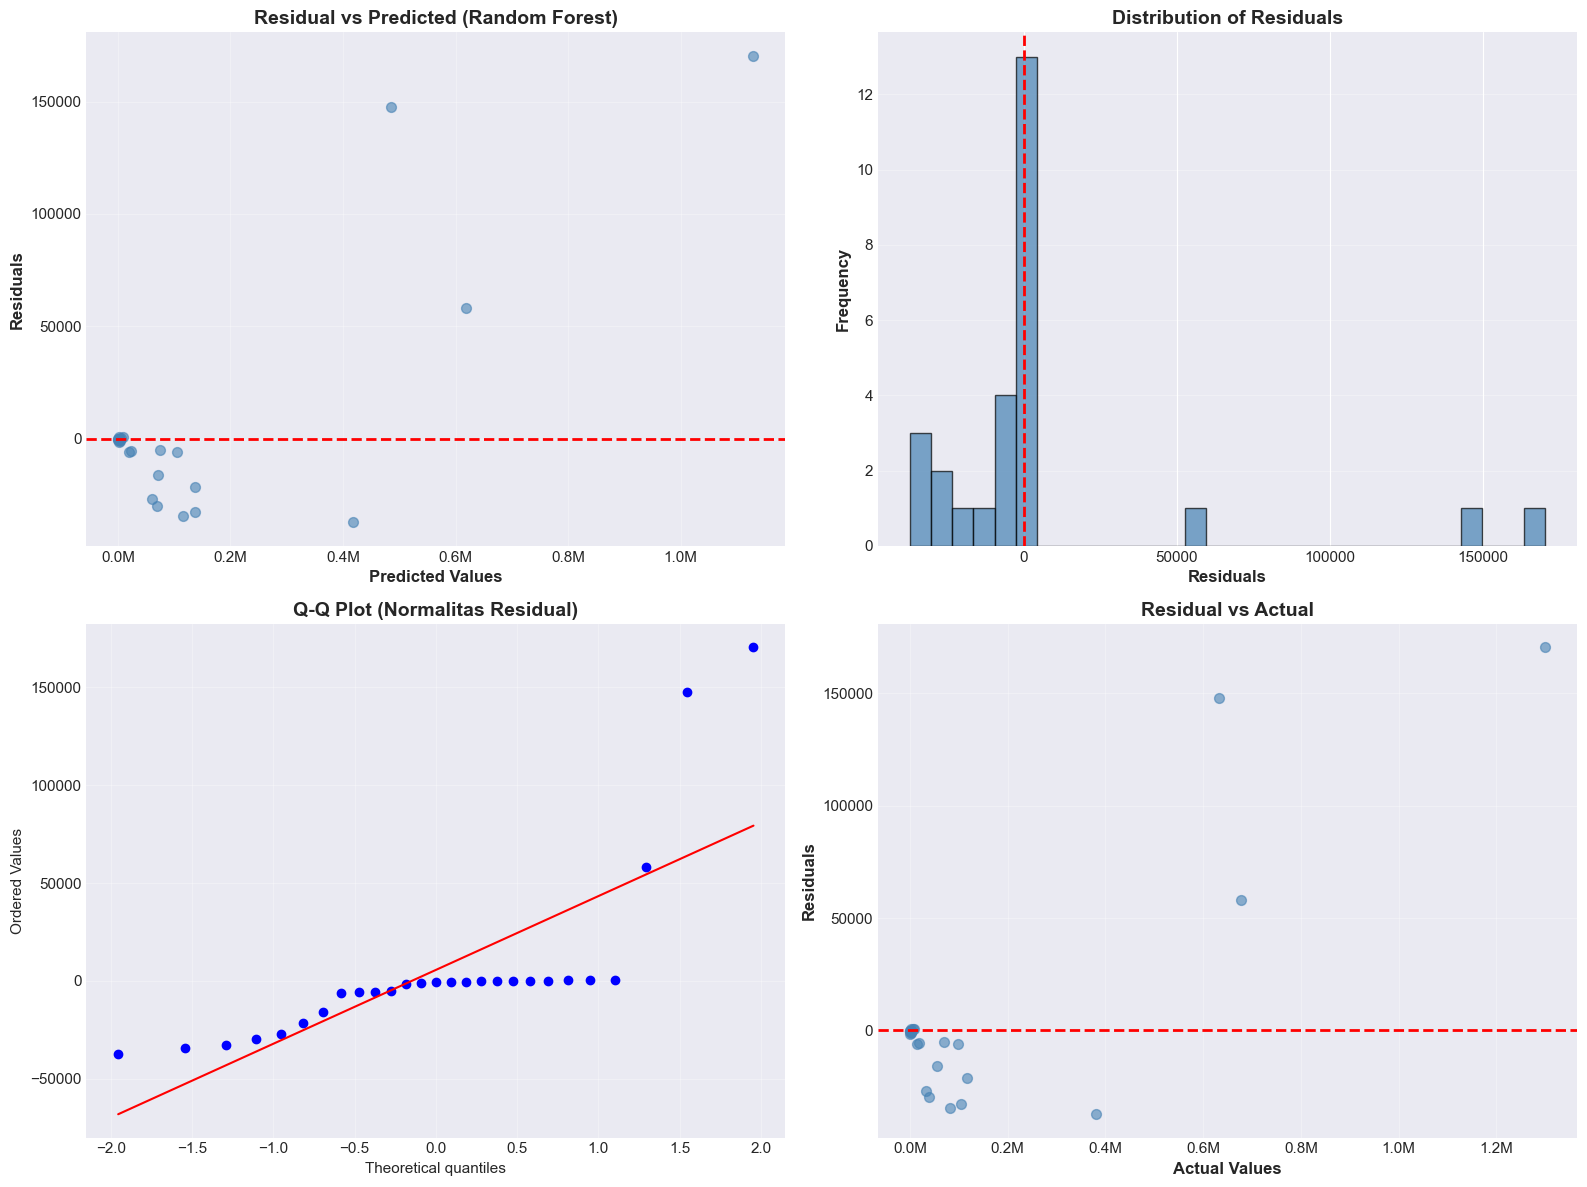


✅ Analisis residual berhasil dilakukan!

💡 Interpretasi:
   - Residual plot yang baik: scatter random tanpa pola
   - Histogram residual: sebaiknya normal
   - Q-Q plot: titik-titik mendekati garis diagonal


In [24]:
# Visualisasi Residual Analysis untuk Model Terbaik
print("=" * 80)
print("📊 ANALISIS RESIDUAL - Model Terbaik")
print("=" * 80)

# Pilih model terbaik
if best_model_name == "Random Forest":
    y_pred_best = y_test_pred_rf
else:
    y_pred_best = y_test_pred_lr

# Hitung residual
residuals = y_test - y_pred_best

# Visualisasi residual
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residual vs Predicted
axes[0, 0].scatter(y_pred_best, residuals, alpha=0.6, color='steelblue', s=50)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Residual vs Predicted ({best_model_name})', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# 2. Histogram Residuals
axes[0, 1].hist(residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q Plot untuk normalitas residual
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalitas Residual)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual vs Actual
axes[1, 1].scatter(y_test, residuals, alpha=0.6, color='steelblue', s=50)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Residual vs Actual', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("\n✅ Analisis residual berhasil dilakukan!")
print("\n💡 Interpretasi:")
print("   - Residual plot yang baik: scatter random tanpa pola")
print("   - Histogram residual: sebaiknya normal")
print("   - Q-Q plot: titik-titik mendekati garis diagonal")
